This notebook is aiming at extracting text from PDF files. We'll be using Amazon Textract service and call it via boto3 API.

Prerequisite: 

1) Valid AWS account with permission to call Textract services

2) PDF files stored in S3 bucket

Output:

Extracted text files will be saved to one Dataframe and stored locally named "Textract_output.csv" 

In [ ]:
# Import required Python libraries
import boto3
import random
import time
import pandas as pd

from textractcaller.t_call import get_full_json, call_textract, Textract_Features, Textract_API

In [ ]:
# Specify location of PDF files
textract = boto3.client('textract',region_name='us-east-1')
s3 = boto3.client('s3')
bucket = "scio-saas-datastores"
path = "SaaS_workspace/aws_textract/inputs/train-04/"

In [ ]:
# List all PDF filename and save them to file_list
paginator = s3.get_paginator('list_objects')
pages = paginator.paginate(Bucket = bucket, Prefix = path)
file_list = []


for page in pages:
    for obj in page['Contents']:
        file_list.append(obj['Key'])

In [ ]:
# In case the first item in file_list is empty, remove first empty path. Check the length of filename list
file_list_new = []
for item in file_list:
    if ".pdf" in item.split("./")[-1]:
        file_list_new.append(item)
file_list = file_list_new.copy()
file_list_len = len(file_list)
len(file_list)

In [ ]:
# Create DataFrame to save extract text
textract_df = pd.DataFrame()

##### Main part to extract PDF files

Error handling: 

During the process, the log file will be printed and if one file is triggling any types of error, we can check the log file and identify the error file. 


#### Service quotas

According to Textract quotas, PDF and TIFF files have a limit of 3,000 pages. (https://docs.aws.amazon.com/textract/latest/dg/limits-document.html)

The current design doesn't consider the case when PDF pages are over 3,000. 

In [ ]:
# Document start time
start_time = time.time()

# Execute conversion for every 100 files
seg_number = file_list_len // 10 + 1

for each_seg in range(seg_number):
    # define file_list to execute, 10 files per segment
    if each_seg == seg_number - 1:
        file_list_segm = file_list[(10 * each_seg):]
    else:
        file_list_segm = file_list[(10 * each_seg): (10 * (each_seg + 1))]
        
    job_id_dict = {}
    for item in file_list_segm:
        response = textract.start_document_text_detection(
                DocumentLocation={'S3Object' : {'Bucket' : bucket,
                                               "Name" : item}
                                 },
                ClientRequestToken = str(random.randint(1, 1e10))
                )
        jobid = response['JobId']
        job_id_dict[jobid] = item
    
    print("seg_num: ", each_seg)
    # Extract PDF using Textract
    for idx, output in enumerate(job_id_dict.keys()):
        print(idx)
        try:
            #print(output['JobId'])
            response = get_full_json(
                job_id = output,
                textract_api = Textract_API.DETECT,
                boto3_textract_client = textract
            )

            pages = response
            page_lines = {}


            for item in pages["Blocks"]:
                if item["BlockType"] == "LINE":
                    if item["Page"] in page_lines.keys():
                        page_lines[item["Page"]].append(item["Text"])
                    else:
                        page_lines[item["Page"]] = []

            for key in page_lines.keys():
                page_lines[key] = ''.join(page_lines[key]).strip()
        except:
            print(job_id_dict[output].split('/')[-1] + " has error")

        for each_page in page_lines.keys():
            new_page = pd.DataFrame([{'file_name' : job_id_dict[output].split('/')[-1], 
                                      "page" : each_page, "content" : page_lines[each_page]}])
            textract_df = pd.concat([textract_df, new_page], ignore_index=True)
            
    # In case running out of memory, save outputs in every 10 steps
    textract_df.to_csv("Textract_output.csv", index=False)
    end_time = time.time()
    time_diff = end_time - start_time
    print("Current Execution time is: " + str(time_diff) + " seconds")    

Example of printed log:
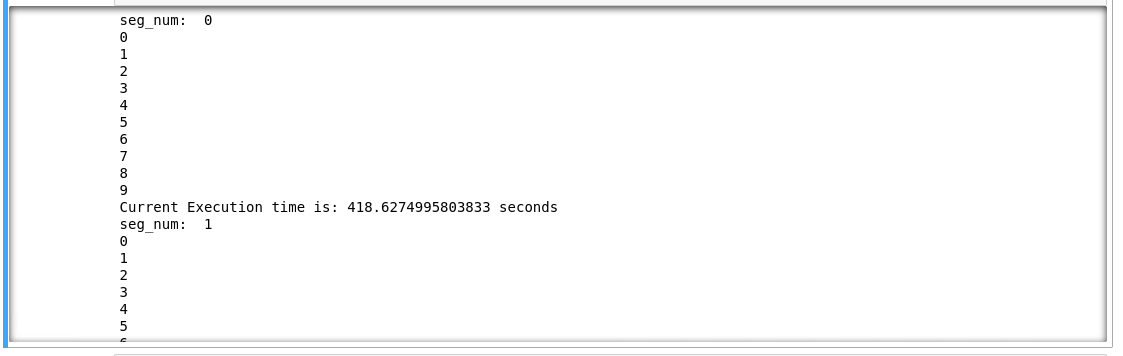

##### Optional: Files hitting Textract Limitation

When running Textract job on NON-OCR data, we found several files are that hitting the limitation of Textract service (either the file size is over 500MB or it contains more than 3000 pages). In either way, Textract can't converted the full file to text, and in current setup we will just remove these error files from Textract_df list.

In [ ]:
# 1) Identify error file name in printed log and save it to a list
error_list = ['1003700000000845044_11500178.pdf', '1003700000000845580_11505270.pdf',
             '1003700000000845625_11498233.pdf', '1003700000000845790_11506268.pdf',
             '1003700000000849628_11494247.pdf', '1003700000000850023_11488853.pdf']

In [ ]:
# 2) Exclude the error files in our dataframe
textract_df_wo_error = textract_df[~textract_df['file_name'].isin(error_list)]
textract_df_wo_error

In [ ]:
# 3) Save this error file free dataframe to local and use it further
textract_df_wo_error.to_csv("non_ocr_2_with_metainfo.csv", index=False)